# Import

In [2]:
import os
import sys
import datetime
import time
import subprocess

import pandas as pd
import numpy
import numpy as np

from scipy import interpolate

import zipfile

import matlab.engine
import optuna

import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import optuna.visualization

import matplotlib.pyplot as plt

import utils

C:\Users\ktt2yk\.conda\envs\ktt2yk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PMSe

## MakeSim

In [3]:
def MakeSim(Appl, l_Dcm, Sim, PMSe_Variant):
    Command = f'c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c={Appl}\n'
    print(Command)
    subprocess.call(Command, shell=True)
    
    Command = f'c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var={PMSe_Variant}\n'
    print(Command)
    subprocess.call(Command, shell=True)
    
    for Dcm in l_Dcm:
        Command = f'c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d={Dcm}\n'
        print(Command)
        subprocess.call(Command, shell=True)
    
    Command = f'c:\TSDCT\SharCC_PMSe\spmse.exe saveSIM -s={Sim}\n'
    print(Command)
    subprocess.call(Command, shell=True)
    
    root, ext = os.path.splitext(Sim)
    Dcm = f'{root}.dcm'
    Command = f'c:\TSDCT\SharCC_PMSe\spmse.exe saveDCM -f={Dcm}\n'
    print(Command)
    subprocess.call(Command, shell=True)
    
    Command = "c:\TSDCT\SharCC_PMSe\spmse.exe exit"
    print(Command)
    subprocess.call(Command, shell=True)
    
    return Sim, Dcm

## MakeHex

In [64]:
def MakeHex(Appl, l_Dcm, Hex, PMSe_Variant, VarCode):
    Command = f'c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c={Appl}\n'
    print(Command)
    subprocess.call(Command, shell=True)
    
    Command = f'c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var={PMSe_Variant}\n'
    print(Command)
    subprocess.call(Command, shell=True)
    
    # Command = f'c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -vc={VarCode}\n'
    # print(Command)
    # subprocess.call(Command, shell=True)
    
    for Dcm in l_Dcm:
        Command = f'c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d={Dcm}\n'
        print(Command)
        subprocess.call(Command, shell=True)
     
    Command = f'c:\TSDCT\SharCC_PMSe\spmse.exe saveHEX -hex={Hex}\n'
    print(Command)
    subprocess.call(Command, shell=True)
    
    root, ext = os.path.splitext(Hex)
    Dcm = f'{root}.dcm'
    Command = f'c:\TSDCT\SharCC_PMSe\spmse.exe saveDCM -f={Dcm}\n'
    print(Command)
    subprocess.call(Command, shell=True)
    
    Command = "c:\TSDCT\SharCC_PMSe\spmse.exe exit"
    print(Command)
    subprocess.call(Command, shell=True)
    
    return Hex, Dcm

# MakeDCM

## MakeDCM

In [5]:
def MakeDCM(d_Par, DCM):
    Out = "KONSERVIERUNG_FORMAT 2.0\n\n"
    
    for Par in d_Par:
        Type, X, Y, Z = d_Par[Par]

        if Type == "FESTWERT TEXT":
            l_Text = ['FESTWERT', '   TEXT', 'END']

            for i, T in enumerate(l_Text):
                if i == 0:
                    Out += f'{T} {Par}\n'
                elif i == 1:
                    Out += f'{T} {str(Z[0])}\n'
                elif i == 2:
                    Out += f'{T}\n'    
        
        if Type == "FESTWERT":
            l_Text = ['FESTWERT', '   WERT', 'END']

            for i, T in enumerate(l_Text):
                if i == 0:
                    Out += f'{T} {Par}\n'
                elif i == 1:
                    Out += f'{T} {str(Z[0])}\n'
                elif i == 2:
                    Out += f'{T}\n'        

        elif Type == "KENNLINIE":
            l_Text = ['KENNLINIE', '   ST/X', '   WERT', 'END']

            Out1 = ''
            Out2 = ''
            for x, z in zip(X, Z):
                Out1 += ' ' + str(x)
                Out2 += ' ' + str(z)

            for i, T in enumerate(l_Text):
                if i == 0:
                    Out += T + ' ' + Par + ' ' + str(len(X)) + '\n'
                elif i == 1: 
                    Out += T + Out1 + '\n'
                elif i == 2:
                    Out += T + Out2 + '\n'
                elif i == 3:
                    Out += T + '\n'  

        elif Type == "KENNFELD":
            l_Text = ['KENNFELD', '   ST/X', '', 'END']

            Z_array = np.array(Z)
            Z_reshaped_array = array.reshape(len(X), len(Y))

            Out1 = ''
            for x in X:
                Out1 += ' ' + str(x)

            Out2 = ''
            for y, z_array in zip(Y, Z_reshaped_array):
                Out2 += '   ST/Y   ' + str(y) + '\n' + '   WERT'

                for z in z_array:
                    Out2 += ' ' + str(z)

                Out2 += '\n'

            for i, T in enumerate(l_Text):
                if i == 0:
                    Out += T + ' ' + Par + ' ' + str(len(X)) + ' ' + str(len(Z)) + '\n'
                elif i == 1: 
                    Out += T + Out1 + '\n'
                elif i == 2:
                    Out += Out2
                elif i == 3:
                    Out += T + '\n'
                    
        Out += '\n' 

    print(Out)
        
    now = datetime.datetime.now()
    filename = now.strftime("%Y-%m-%d_%H-%M-%S-%f")
    
    directory_path = os.path.dirname(DCM)
    # basename_without_ext = os.path.splitext(os.path.basename(DCM))[0]
    Dcm = directory_path + '\\' + filename + ".dcm"

    f = open(Dcm, "w")
    f.write(Out)
    f.close()
    
    return Dcm

# Evaluation

## Change Format
- D97 ==> CSV ==> DataFrame

In [6]:
def Convert_D97_to_CSV(l_Sig_PLT, D97):
    filename = os.path.splitext(D97)[0]
    PLT = filename + '.plt'        
    
    PLT = Make_PLT(l_Sig_PLT, PLT)
    CSV = Run_Command(D97, PLT)
    CSV = Insert_Col(CSV, l_Sig_PLT)
    
    return CSV, PLT


def Run_Command(D97, PLT):
    filename = os.path.splitext(D97)[0]
    D97_1 = filename + '_1.d97'
    D97_2 = filename + '_2.d97'
    CSV = filename + '.csv'
    
    Command = "MDFDSET6c ifn=" + D97 + ";pltfn=" + PLT + " ofn=" + D97_1 + "\n"
    # print(Command)
    subprocess.call(Command, shell=True)
    
    Command = "MDFMDL6c ifn=" + D97_1 + " ofn=" + D97_2 + " tc=0.005" + "\n"
    # print(Command)
    subprocess.call(Command, shell=True)
    Remove_FILE(D97_1)
    
    # MDFDSET3c ifn=BS188.D97 ofn=BS188.MDF
    Command = "MDFDSET3c ifn=" + D97_2 + " ofn=" + CSV + '\n'
    # Command = "SDTM3c ifn=" + D97_2 + " ofn=" + CSV
    # print(Command)
    subprocess.call(Command, shell=True)
    Remove_FILE(D97_2)
        
    return CSV


def Make_PLT(l_Sig, File):
    Text = ''
    
    l_Sig.sort()
    
    for S in l_Sig:
        Text += S + '\n'

    with open(File, 'w') as file:
        file.write(Text)
        
    return File


def Insert_Col(File, l_Sig):
    df = pd.read_csv(File, delimiter="\t")
    df.columns = ['TIME'] + l_Sig
    
    df.to_csv(File, index=None)
    # print(len(df.columns))
    
    return File


def Remove_FILE(file_path):
    try:
        os.remove(file_path)
    except FileNotFoundError:
        print(f'FileNotFoundError: {file_path}')
    except Exception as e:
        print(e)

## LaneChange

In [7]:
def VDC_LaneChange_Evaluation_w_D97(D97, Sig, df_tar):
    CSV, PLT = Convert_D97_to_CSV([Sig], D97)
    l_Trash = []
    # l_Trash.append(CSV)
    l_Trash.append(PLT)
    
    now = datetime.datetime.now()
    filename = now.strftime("%Y-%m-%d_%H-%M-%S-%f")
    
    directory_path = os.path.dirname(CSV)
    # basename_without_ext = os.path.splitext(os.path.basename(DCM))[0]
    CSV_ = directory_path + '\\' + filename + ".csv"
    os.rename(CSV, CSV_)

    df = pd.read_table(CSV_, sep=",", index_col=None, header=0)
    
    # evaluation = mean_absolute_error(df[Sig], df_tar[Sig])
    evaluation = mean_squared_error(df[Sig], df_tar[Sig])
#     _ = df[Sig] - df_tar[Sig]
#     _ = _.abs()
#     evaluation = _.sum()
    
    fig = plt.figure(figsize=(6, 2))
    
    x = df.index
    y = df[Sig]
    plt.plot(x, y, label='sim')
    
    x = df_tar.index
    y = df_tar[Sig]    
    plt.plot(x, y, label='tar')
    
    plt.legend()
    plt.xlim(2000, 3000) 
    plt.show()    
    
    for File in l_Trash:
        Remove_FILE(File)
    
    return evaluation, CSV_

## ABS Evaluation

In [8]:
def ABS_Evaluation_w_CSV(CSV, CSV_out, Add_LABEL):
    if Add_LABEL == True:
        l_SIGNAL_LABEL = ['TIME',
                          'AVy_L1', 
                          'AVy_R1', 
                          'AVy_L2', 
                          'AVy_R2', 
                          'Steer_SW',
                          'Pbk_Con',
                          'AVz',
                          'Throttle',
                          'gearStat',
                          'M_Eng_In',
                          'AV_Eng',
                          'Ax_SM',
                          'Ay_SM',
                          'Vx',
                          'Vx_L1',
                          'Vx_R1',
                          'Vx_L2',
                          'Vx_R2',
                          'PbkCh_L1',
                          'PbkCh_L2',
                          'PbkCh_R1',
                          'PbkCh_R2',
                          'Pitch',
                          'Roll',
                          'Yaw',
                          'Xo',
                          'X_Design',
                          'Yo',
                          'Y_Design']                  

        df = pd.read_table(CSV, sep=",", header=None, names=l_SIGNAL_LABEL)
        
    else:
        df = pd.read_table(CSV, sep=",")
 
    df = ABS_Calculation_Evaluation_Value(df)
    evaluation = ABS_Evaluation(df)
    
    df.to_csv(CSV_out, index=None)
    
    return evaluation, CSV_out

In [9]:
def ABS_Calculation_Evaluation_Value(df):
    global Poo
    Poo = df
    
    l_sl_FL = []
    l_sl_FR = []
    l_sl_RL = []
    l_sl_RR = []

    l_E_vFL = []
    l_E_vFR = []
    l_E_vRL = []
    l_E_vRR = []

    for Index in df.index:
        Vx = df.at[Index, 'Vx']
        Vx_FL = df.at[Index, 'Vx_L1']
        Vx_FR = df.at[Index, 'Vx_L1']
        Vx_RL = df.at[Index, 'Vx_L2']
        Vx_RR = df.at[Index, 'Vx_R2']

        sl_FL = (Vx - Vx_FL) / Vx
        sl_FR = (Vx - Vx_FR) / Vx
        sl_RL = (Vx - Vx_RL) / Vx
        sl_RR = (Vx - Vx_RR) / Vx

        E_vFL = Evaluation_Wheel_Slip_FA(Vx, sl_FL)
        E_vFR = Evaluation_Wheel_Slip_FA(Vx, sl_FR)
        E_vRL = Evaluation_Wheel_Slip_RA(Vx, sl_RL)
        E_vRR = Evaluation_Wheel_Slip_RA(Vx, sl_RR)

        l_sl_FL.append(sl_FL)
        l_sl_FR.append(sl_FR)
        l_sl_RL.append(sl_RL)
        l_sl_RR.append(sl_RR)

        l_E_vFL.append(E_vFL)
        l_E_vFR.append(E_vFR)
        l_E_vRL.append(E_vRL)
        l_E_vRR.append(E_vRR)

    df['sl_FL'] = l_sl_FL
    df['sl_FR'] = l_sl_FR
    df['sl_RL'] = l_sl_RL
    df['sl_RR'] = l_sl_RR

    df['E_vFL'] = l_E_vFL
    df['E_vFR'] = l_E_vFR
    df['E_vRL'] = l_E_vRL
    df['E_vRR'] = l_E_vRR
    
    return df

In [10]:
def Evaluation_Wheel_Slip_FA(Vx, Dev_vXX):
    X = [0, 5, 10, 20, 40, 60, 80, 100, 120, 300]
    Y = [-0.1, 0, 0.03, 0.07, 0.1, 0.15, 0.2, 0.3, 1]
    Z = [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, -1, -1, -1, -1, -1, -1, -1, -1]]
    
    Z_ = []
    for _ in Z:
        Z_ += _ 
    
    Z = np.reshape(Z_, (len(Y), len(X)))
    
    if Vx > X[-1]:
        value_x = X[-1]
    elif Vx < X[0]:
        value_x = X[0]
    else:
        value_x = Vx

    if Dev_vXX > Y[-1]:
        value_y = Y[-1]
    elif Dev_vXX < Y[0]:
        value_y = Y[0]
    else:
        value_y = Dev_vXX
    
    f = interpolate.interp2d(X, Y, Z)
    Out = f(Vx, Dev_vXX)    
    
    return Out[0]

In [11]:
def Evaluation_Wheel_Slip_RA(Vx, Dev_vXX):
    X = [0, 5, 10, 20, 40, 60, 80, 100, 120, 300]
    Y = [-0.1, 0, 0.03, 0.07, 0.1, 0.15, 0.2, 0.3, 1]
    Z = [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, -1, -1, -1, -1, -1, -1, -1, -1]]
    
    Z_ = []
    for _ in Z:
        Z_ += _ 
    
    Z = np.reshape(Z_, (len(Y), len(X)))
    
    if Vx > X[-1]:
        value_x = X[-1]
    elif Vx < X[0]:
        value_x = X[0]
    else:
        value_x = Vx

    if Dev_vXX > Y[-1]:
        value_y = Y[-1]
    elif Dev_vXX < Y[0]:
        value_y = Y[0]
    else:
        value_y = Dev_vXX
    
    f = interpolate.interp2d(X, Y, Z)
    Out = f(Vx, Dev_vXX)    
    
    return Out[0]

In [12]:
def ABS_Evaluation(df):
    df_if = df[(df['Pbk_Con'] > 2) & (df['Vx'] < 0.5)]
    
    if len(df_if) > 10:
        df_ = df[df['Pbk_Con'] > 0.5]
        Distance = df_['Xo'].max() - df_['Xo'].min()

        df_ = df[(df['Pbk_Con'] > 0.5) & (df['Vx'] > 0.5)]
        E = (df_['E_vFL'].sum() + df_['E_vFR'].sum() + df_['E_vRL'].sum() + df_['E_vRR'].sum()) / len(df_)
        Deceleration = df_['Ax_SM'].mean()
    else:
        E = -10000
        Distance = 10000
        Deceleration = 10000
    
    return (E, Distance, Deceleration)

# Matlab

## Run_Matlab

In [11]:
def Run_Matlab(matlab_path, dir_path, model_path, d97_path, csv_path):
    if os.path.exists(d97_path) == True:
        os.remove(d97_path)
        
    if os.path.exists(csv_path) == True:
        os.remove(csv_path)
        
    script_path = f'{dir_path}\\AutoTuning.m'
    
    if os.path.exists(script_path) == True:
        os.remove(script_path)
    
    with open(script_path, 'w') as file:
        T = f"sim('{os.path.basename(model_path)}')"
        # print(T)
        file.write(T)
    
    command = f'"{matlab_path}" -nosplash -nodesktop -r "run(\'{script_path}\');exit;"'

    subprocess.run(command, shell=True)
    
    Time = 0
    while not os.path.exists(csv_path):
        time.sleep(1)
        Time += 1
        
        if Time == 60 * 30:
            break
    
    time.sleep(30)

## PACK_to_ZIP

In [12]:
def PACK_to_ZIP(Zip_Out, files_to_zip):
    # os.rename(D97, D97_Out)
    
    # files_to_zip = [D97_Out, Dcm]

    with zipfile.ZipFile(Zip_Out, 'w') as zipf:
        for file in files_to_zip:
            zipf.write(file, os.path.basename(file))
            
    # os.remove(D97_Out)
    # os.remove(Dcm)

In [13]:
def FileName(count, dir_path):
    now = datetime.datetime.now()
    filename = now.strftime("%Y%m%d%H%M%S%f")
    
    # directory_path = os.path.dirname(File)
    directory_path = dir_path
    # basename_without_ext = os.path.splitext(os.path.basename(DCM))[0]
    Csv = f'{directory_path}\\Traial_{count}_{filename}.csv'
    Zip = f'{directory_path}\\Traial_{count}_{filename}.zip'
    D97 = f'{directory_path}\\Traial_{count}_{filename}.d97'
    
    return Csv, Zip, D97

# Parameter Tuning

In [14]:
DIR = 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN'

FILE_Appl = f'{DIR}\\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip'
FILE_Sim = f'{DIR}\\DG8B_BB87971_Var01_Auto.sim'
# FILE_Sim_Txt = 'C:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CarSim_HGT_3A0A_BB83182_Var81_20230516\\3A0A_BB81382_Var81_AddressValues_sim.txt'
DCM_Org = f'{DIR}\\Complete_ESP10_BB87971_VarCode_1_org.dcm'
FILE_D97 = f'{DIR}\\oml_bbxxxxx.d97'
FILE_Model = f'{DIR}\\CSSim_model_bbxxxxx_CarSim_HM_DG8B_externalPT_20231020_dTCS.mdl'
# FILE_CSV = f'{DIR}\\oml_bbxxxxx_tar.csv'
FILE_CSV = f'{DIR}\\simout_w_carsim.csv'
PMSe_Variant = 'ESP10_BB87971'

MATLAB = "C:\\Program Files\\MATLAB\\R2012b\\bin\\matlab.exe"

## Run

In [15]:
l_eval = []

# df_TAR = pd.read_table(FILE_CSV, sep=",", index_col=None, header=0)

# matlab_version = "R2012b"
# matlab_version = "R2022b"
# eng = matlab.engine.start_matlab(f"matlab.engine.shareEngine('{matlab_version}')")
COUNT = 0

def objective(trial):
    global COUNT
    
    FS_ABS_ACH = trial.suggest_categorical('FS_ABS_ACH', ['"ON"', '"OFF"'])
    # FS_ABS_DeSyncro_RA = trial.suggest_categorical('FS_ABS_DeSyncro_RA', ['"ON"', '"OFF"'])
    GMA_MDiff_Ende_RA = trial.suggest_int('GMA_MDiff_Ende_RA', 200, 800)
    Opt_Instabil_Learn_aRad_HA_Z0 = trial.suggest_int('Opt_Instabil_Learn_aRad_HA_Z0', 10, 40)
    Opt_Instabil_Learn_aRad_HA_Z1 = trial.suggest_int('Opt_Instabil_Learn_aRad_HA_Z1', 10, 40)
    Opt_Instabil_Learn_aRad_HA_Z2 = trial.suggest_int('Opt_Instabil_Learn_aRad_HA_Z2', 10, 40)
    Opt_Instabil_DP_HA_Z0 = trial.suggest_int('Opt_Instabil_DP_HA_Z0', 4, 20)
    Opt_Instabil_DP_HA_Z1 = trial.suggest_int('Opt_Instabil_DP_HA_Z1', 4, 20)
    Opt_Instabil_DP_HA_Z2 = trial.suggest_int('Opt_Instabil_DP_HA_Z2', 4, 20)
    Opt_Instabil_DP_HA_Z3 = trial.suggest_int('Opt_Instabil_DP_HA_Z3', 4, 20)
    Opt_Normal_DruckStartSprungMax_MueMid_RA = trial.suggest_float('Opt_Normal_DruckStartSprungMax_MueMid_RA', 3, 9)
    Opt_Normal_P25_MueMid_RA = trial.suggest_int('Opt_Normal_P25_MueMid_RA', 2, 7)
    Opt_Normal_RampGradient_P25_MueMid_RA = trial.suggest_int('Opt_Normal_RampGradient_P25_MueMid_RA', 30, 90)
    # P4 = trial.suggest_float('P4', 0.08, 0.30)
    # P5 = trial.suggest_float('P5', 2, 6)
    # Z2 = trial.suggest_int('Z2', 1000, 1300)
    # Z3 = trial.suggest_int('Z3', 300, 800)
    
    l_DCM = [DCM_Org]
    d_Par = {}

    X = []
    Y = []
    Z = [FS_ABS_ACH]
    d_Par['FS_ABS_ACH'] = ('FESTWERT TEXT', X, Y, Z)
    
    X = []
    Y = []
    Z = [FS_ABS_ACH]
    d_Par['FS_ABS_DeSyncro_RA'] = ('FESTWERT TEXT', X, Y, Z)
    
    X = []
    Y = []
    Z = [GMA_MDiff_Ende_RA]
    d_Par['GMA_MDiff_Ende_RA'] = ('FESTWERT', X, Y, Z)
    
    X = []
    Y = []
    Z = [GMA_MDiff_Ende_RA]
    d_Par['GMA_MDiff_Ende_noSplit_RA'] = ('FESTWERT', X, Y, Z)

    X = []
    Y = []
    Z = [GMA_MDiff_Ende_RA]
    d_Par['GMA_MDiff_SideChange_RA'] = ('FESTWERT', X, Y, Z)

    X = [10.0, 30.0, 50]
    Y = []
    Z = [Opt_Instabil_Learn_aRad_HA_Z0, Opt_Instabil_Learn_aRad_HA_Z1, Opt_Instabil_Learn_aRad_HA_Z2]
    d_Par['Opt_Instabil_Learn_aRad_HA'] = ('KENNLINIE', X, Y, Z)
    
    X = [5.0, 30.0, 40.0, 50.0]
    Y = []
    Z = [Opt_Instabil_DP_HA_Z0, Opt_Instabil_DP_HA_Z1, Opt_Instabil_DP_HA_Z2, Opt_Instabil_DP_HA_Z3]
    d_Par['Opt_Instabil_DP_HA'] = ('KENNLINIE', X, Y, Z)
    
    X = []
    Y = []
    Z = [Opt_Normal_DruckStartSprungMax_MueMid_RA]    
    d_Par['Opt_Normal_DruckStartSprungMax_MueMid_RA'] = ('FESTWERT', X, Y, Z)

    X = []
    Y = []
    Z = [Opt_Normal_P25_MueMid_RA]    
    d_Par['Opt_Normal_P25_MueMid_RA'] = ('FESTWERT', X, Y, Z)
    
    X = []
    Y = []
    Z = [Opt_Normal_RampGradient_P25_MueMid_RA]    
    d_Par['Opt_Normal_RampGradient_P25_MueMid_RA'] = ('FESTWERT', X, Y, Z)
    
    DCM = MakeDCM(d_Par, DCM_Org)
    l_DCM.append(DCM)
    
    SIM, DCM_update = MakeSim(FILE_Appl, l_DCM, FILE_Sim, PMSe_Variant)
    
    # result = eng.sim(FILE_Model)
    FILE_ZIP = Run_Matlab(MATLAB, DIR, FILE_Model, FILE_D97, FILE_CSV)
    
    FILE_CSV_OUT, ZIP_OUT, D97_OUT = FileName(COUNT, DIR)
    
    Eva, CSV = ABS_Evaluation_w_CSV(FILE_CSV, FILE_CSV_OUT, True)
    E_Slip, Distance, Deceleration = Eva
    
    e = Distance
    print(f'Trial:{COUNT}, Evaluation:{e}')
    
    # os.rename(D97, D97_Out)
    # PACK_to_ZIP(ZIP_OUT, [D97_OUT, DCM_update, CSV])
    PACK_to_ZIP(ZIP_OUT, [DCM_update, CSV])
    os.remove(DCM)
    # os.remove(D97_OUT)
    
    l_eval.append((e, CSV, d_Par))
    
    COUNT += 1
    
    return e


study = optuna.create_study(direction='minimize')
# study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

study.best_params  # E.g. {'x': 2.002108042}

# Matlabを終了する
# eng.quit()


now = datetime.datetime.now()
time = now.strftime("%Y%m%d%H%M%S%f")
FILE_RESULT = f'Sim_Result_{time}.pkl'
with open(FILE_RESULT, 'wb') as file:
    pickle.dump((l_eval, study), file)

[I 2023-12-26 09:03:28,256] A new study created in memory with name: no-name-61de6e37-22c9-4e06-b8b9-83bafb0d04b5


KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "OFF"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "OFF"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 462
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 462
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 462
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 37 19 13
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 19 9 6 19
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.54502279303634
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 3
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 32
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:0, Evaluation:33.110000000000014
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 750
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 750
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 750
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 24 15 16
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 16 20 7 19
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.1801111922443788
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 52
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:1, Evaluation:32.59
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 517
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 517
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 517
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 26 16 11
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 16 9 8 7
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.3840981413989133
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 5
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 82
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_B

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:2, Evaluation:33.24000000000001
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "OFF"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "OFF"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 629
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 629
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 629
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 26 22 11
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 10 11 17 17
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.984093411345098
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 6
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 31
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CAR

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:3, Evaluation:33.170000000000016
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "OFF"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "OFF"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 574
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 574
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 574
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 29 19 29
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 5 19 7 5
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 8.290730022008198
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 2
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 65
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSI

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:4, Evaluation:33.420000000000016
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "OFF"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "OFF"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 650
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 650
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 650
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 11 35 27
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 12 16 13 11
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 7.764272039629845
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 5
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 37
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CA

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:5, Evaluation:33.24000000000001
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "OFF"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "OFF"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 767
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 767
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 767
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 11 40 29
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 14 18 7 9
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 8.660288130224007
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 3
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 86
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSI

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:6, Evaluation:33.420000000000016
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "OFF"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "OFF"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 421
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 421
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 421
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 39 39 23
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 5 20 19 16
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 8.16563685760057
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 63
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:7, Evaluation:33.43000000000001
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 268
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 268
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 268
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 33 32 23
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 12 5 4 6
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 8.745905886670371
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 2
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 88
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\C

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:8, Evaluation:32.99000000000001
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "OFF"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "OFF"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 780
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 780
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 780
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 33 33 39
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 12 5 16 11
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 7.194057207802154
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 5
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 74
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:9, Evaluation:33.48000000000002
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 323
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 323
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 323
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 18 12 18
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 20 15 12 15
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 5.024196890185875
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 7
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 47
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSI

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:10, Evaluation:32.95000000000002
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 228
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 228
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 228
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 18 10 18
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 20 15 11 15
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.840911157831184
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 7
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 48
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:11, Evaluation:32.95000000000002
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 354
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 354
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 354
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 19 12 17
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 17 14 12 20
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.632527612494532
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 7
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 49
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:12, Evaluation:32.78
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 368
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 368
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 368
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 20 26 17
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 17 13 10 20
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.24651214733981
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 51
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:13, Evaluation:32.629999999999995
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 373
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 373
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 373
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 22 27 15
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 16 11 9 18
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.26105470339491
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 54
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSI

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:14, Evaluation:32.629999999999995
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 705
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 705
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 705
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 14 26 21
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 17 17 4 13
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.017513826169612
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 3
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 57
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:15, Evaluation:32.920000000000016
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 536
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 536
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 536
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 22 28 39
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 8 13 9 19
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.072477599934111
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 40
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSI

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:16, Evaluation:32.77000000000001
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 439
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 439
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 439
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 30 23 33
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 14 8 15 13
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.132510138863412
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 6
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 68
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSI

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:17, Evaluation:33.0
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 279
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 279
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 279
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 22 16 20
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 18 20 10 20
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 5.731519268426373
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 3
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 42
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:18, Evaluation:32.53999999999999
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 274
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 274
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 274
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 15 15 21
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 14 20 14 17
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 5.979237089078273
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 3
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 41
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:19, Evaluation:32.870000000000005
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 208
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 208
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 208
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 24 17 14
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 18 18 5 18
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 5.8890715276774905
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 2
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 58
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CAR

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:20, Evaluation:32.610000000000014
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 200
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 200
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 200
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 23 17 14
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 18 18 5 18
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 6.013933496873287
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 2
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 57
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:21, Evaluation:32.72
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 273
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 273
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 273
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 28 14 10
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 15 20 6 20
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 6.006075041802056
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 2
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 44
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:22, Evaluation:32.650000000000006
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 310
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 310
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 310
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 25 20 20
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 19 18 8 16
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 6.600520215279895
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 3
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 72
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:23, Evaluation:32.900000000000006
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 214
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 214
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 214
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 24 13 15
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 18 17 10 18
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 5.491846025933465
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 3
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 60
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CAR

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:24, Evaluation:32.45000000000002
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 694
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 694
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 694
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 21 11 24
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 16 16 10 14
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 5.359568636825323
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 3
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 52
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:25, Evaluation:32.890000000000015
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 601
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 601
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 601
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 15 14 16
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 19 19 11 19
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.211972809290788
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 36
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CAR

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:26, Evaluation:32.610000000000014
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 247
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 247
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 247
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 33 13 19
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 10 16 9 17
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 5.581968265570057
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 3
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 62
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:27, Evaluation:32.70000000000002
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 479
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 479
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 479
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 27 10 26
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 15 20 13 20
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.532910902582091
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 45
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:28, Evaluation:32.58000000000001
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 477
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 477
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 477
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 31 10 27
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 18 17 14 20
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 5.37320680880897
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 5
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 35
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSI

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:29, Evaluation:32.84
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 402
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 402
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 402
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 36 21 34
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 13 19 13 9
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.7178995891224558
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 3
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 44
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:30, Evaluation:32.78999999999999
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 313
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 313
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 313
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 27 17 13
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 15 20 11 19
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.491167339230454
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 45
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:31, Evaluation:32.59
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 482
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 482
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 482
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 24 19 22
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 15 19 7 18
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.601942658226201
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 54
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:32, Evaluation:32.52000000000001
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 476
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 476
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 476
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 24 18 27
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 15 17 10 18
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.6121799282406637
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 54
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CAR

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:33, Evaluation:32.55000000000001
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 567
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 567
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 567
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 24 19 22
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 17 15 8 16
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.7739906293495853
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 5
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 54
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:34, Evaluation:32.650000000000006
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 523
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 523
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 523
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 25 23 25
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 10 17 10 18
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.517868379402476
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 67
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CAR

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:35, Evaluation:32.56999999999999
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "OFF"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "OFF"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 432
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 432
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 432
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 20 16 31
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 20 19 6 15
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.8124668887518243
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 3
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 77
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CA

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:36, Evaluation:33.5
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 551
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 551
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 551
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 23 18 28
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 13 9 7 17
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.5935143594267993
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 3
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 60
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:37, Evaluation:32.74000000000001
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "OFF"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "OFF"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 497
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 497
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 497
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 28 22 12
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 16 17 8 18
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.071003857529748
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 6
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 33
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CAR

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:38, Evaluation:33.03999999999999
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 393
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 393
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 393
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 26 15 25
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 18 19 10 19
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.446357659458333
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 40
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:39, Evaluation:32.69
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "OFF"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "OFF"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 604
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 604
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 604
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 31 19 20
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 4 7 18 16
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.313106994229334
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 5
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 65
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:40, Evaluation:33.48000000000002
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 519
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 519
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 519
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 25 24 25
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 9 17 10 18
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.9543641383288275
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 69
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:41, Evaluation:32.83000000000001
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 456
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 456
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 456
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 17 20 30
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 7 18 11 4
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 3.5200372440546444
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 4
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 67
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSI

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:42, Evaluation:32.370000000000005
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 330
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 330
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 330
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 18 21 31
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 7 18 11 8
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.882936058508207
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 5
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 61
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSI

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:43, Evaluation:32.52000000000001
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 232
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 232
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 232
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 17 21 31
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 7 19 12 5
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 5.049409258741592
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 5
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 81
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:44, Evaluation:32.16
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 338
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 338
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 338
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 17 29 31
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 7 18 12 4
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.838083302167253
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 5
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 82
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:45, Evaluation:32.21000000000001
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "OFF"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "OFF"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 228
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 228
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 228
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 12 30 36
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 6 16 13 4
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 5.099711965250278
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 6
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 83
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARS

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:46, Evaluation:33.27000000000001
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 345
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 345
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 345
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 17 36 30
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 7 14 12 6
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.648442982868488
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 5
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 90
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:47, Evaluation:32.81
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 300
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 300
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 300
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 13 30 34
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 6 19 14 4
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.406257795628213
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 5
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 78
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:48, Evaluation:32.45000000000002
KONSERVIERUNG_FORMAT 2.0

FESTWERT FS_ABS_ACH
   TEXT "ON"
END

FESTWERT FS_ABS_DeSyncro_RA
   TEXT "ON"
END

FESTWERT GMA_MDiff_Ende_RA
   WERT 290
END

FESTWERT GMA_MDiff_Ende_noSplit_RA
   WERT 290
END

FESTWERT GMA_MDiff_SideChange_RA
   WERT 290
END

KENNLINIE Opt_Instabil_Learn_aRad_HA 3
   ST/X 10.0 30.0 50
   WERT 13 29 36
END

KENNLINIE Opt_Instabil_DP_HA 4
   ST/X 5.0 30.0 40.0 50.0
   WERT 5 4 15 4
END

FESTWERT Opt_Normal_DruckStartSprungMax_MueMid_RA
   WERT 4.2877026217099115
END

FESTWERT Opt_Normal_P25_MueMid_RA
   WERT 6
END

FESTWERT Opt_Normal_RampGradient_P25_MueMid_RA
   WERT 79
END


c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_22516\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

Trial:49, Evaluation:32.360000000000014


## Result

In [20]:
l_trial = []
l_e = []

l_FS_ABS_ACH = []
l_GMA_MDiff_Ende_RA = []
l_Opt_Instabil_Learn_aRad_HA_Z0 = []
l_Opt_Instabil_Learn_aRad_HA_Z1 = []
l_Opt_Instabil_Learn_aRad_HA_Z2 = []
l_Opt_Instabil_DP_HA_Z0 = []
l_Opt_Instabil_DP_HA_Z1 = []
l_Opt_Instabil_DP_HA_Z2 = []
l_Opt_Instabil_DP_HA_Z3 = []
l_Opt_Normal_DruckStartSprungMax_MueMid_RA = [] 
l_Opt_Normal_P25_MueMid_RA = []
l_Opt_Normal_RampGradient_P25_MueMid_RA = []

for i, _ in enumerate(l_eval):
    e, csv, d_Par = _
    
    l_trial.append(i)
    l_e.append(e)
    
    l_FS_ABS_ACH.append(d_Par['FS_ABS_ACH'][3][0])
    l_GMA_MDiff_Ende_RA.append(d_Par['GMA_MDiff_Ende_RA'][3][0])
    l_Opt_Instabil_Learn_aRad_HA_Z0.append(d_Par['Opt_Instabil_Learn_aRad_HA'][3][0])
    l_Opt_Instabil_Learn_aRad_HA_Z1.append(d_Par['Opt_Instabil_Learn_aRad_HA'][3][1])
    l_Opt_Instabil_Learn_aRad_HA_Z2.append(d_Par['Opt_Instabil_Learn_aRad_HA'][3][2])
    l_Opt_Instabil_DP_HA_Z0.append(d_Par['Opt_Instabil_DP_HA'][3][0])
    l_Opt_Instabil_DP_HA_Z1.append(d_Par['Opt_Instabil_DP_HA'][3][0])
    l_Opt_Instabil_DP_HA_Z2.append(d_Par['Opt_Instabil_DP_HA'][3][0])
    l_Opt_Instabil_DP_HA_Z3.append(d_Par['Opt_Instabil_DP_HA'][3][0]) 
    l_Opt_Normal_DruckStartSprungMax_MueMid_RA.append(d_Par['Opt_Normal_DruckStartSprungMax_MueMid_RA'][3][0])
    l_Opt_Normal_P25_MueMid_RA.append(d_Par['Opt_Normal_P25_MueMid_RA'][3][0])
    l_Opt_Normal_RampGradient_P25_MueMid_RA.append(d_Par['Opt_Normal_RampGradient_P25_MueMid_RA'][3][0])

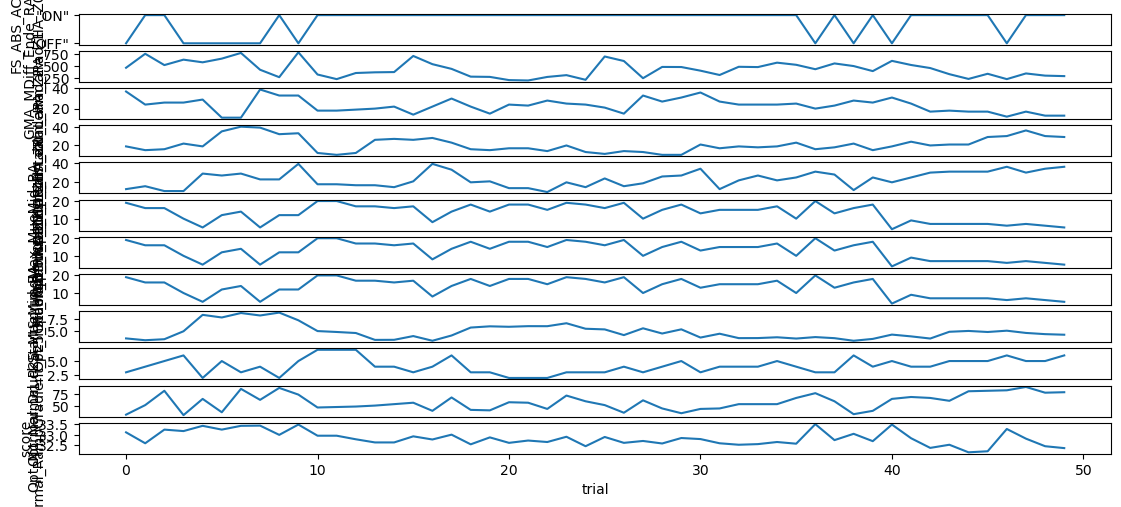

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5), dpi=100)
fig.subplots_adjust(left=0.1, right=0.96, bottom=0.1, top=0.98)

x = l_trial
l_ = [('FS_ABS_ACH', l_FS_ABS_ACH), 
      ('GMA_MDiff_Ende_RA', l_GMA_MDiff_Ende_RA), 
      ('Opt_Instabil_Learn_aRad_HA_Z0', l_Opt_Instabil_Learn_aRad_HA_Z0), 
      ('Opt_Instabil_Learn_aRad_HA_Z1', l_Opt_Instabil_Learn_aRad_HA_Z1), 
      ('Opt_Instabil_Learn_aRad_HA_Z2', l_Opt_Instabil_Learn_aRad_HA_Z2), 
      ('Opt_Instabil_DP_HA_Z0', l_Opt_Instabil_DP_HA_Z0), 
      ('Opt_Instabil_DP_HA_Z1', l_Opt_Instabil_DP_HA_Z1), 
      ('Opt_Instabil_DP_HA_Z2', l_Opt_Instabil_DP_HA_Z2), 
      ('Opt_Normal_DruckStartSprungMax_MueMid_RA', l_Opt_Normal_DruckStartSprungMax_MueMid_RA), 
      ('Opt_Normal_P25_MueMid_RA', l_Opt_Normal_P25_MueMid_RA), 
      ('Opt_Normal_RampGradient_P25_MueMid_RA', l_Opt_Normal_RampGradient_P25_MueMid_RA), 
      ('score', l_e)]

for i, _ in enumerate(l_):
    Label, y = _
    num = i + 1
    ax = fig.add_subplot(len(l_), 1, num)

    ax.plot(x, y)
    ax.set_ylabel(Label)
    
    if i != len(l_)-1:
        ax.set_xticklabels([])
        ax.set_xticks([])
    else:
        ax.set_xlabel('trial')

plt.show()
fig.savefig('Score.png') 

## Best parameters

In [27]:
import pickle

FILE_RESULT = 'Sim_Result_20231226143349644981.pkl'

with open(FILE_RESULT, 'rb') as file:
    l_eval, study = pickle.load(file)

print(study)

In [28]:
print(study.best_params)

{'FS_ABS_ACH': '"ON"', 'GMA_MDiff_Ende_RA': 232, 'Opt_Instabil_Learn_aRad_HA_Z0': 17, 'Opt_Instabil_Learn_aRad_HA_Z1': 21, 'Opt_Instabil_Learn_aRad_HA_Z2': 31, 'Opt_Instabil_DP_HA_Z0': 7, 'Opt_Instabil_DP_HA_Z1': 19, 'Opt_Instabil_DP_HA_Z2': 12, 'Opt_Instabil_DP_HA_Z3': 5, 'Opt_Normal_DruckStartSprungMax_MueMid_RA': 5.049409258741592, 'Opt_Normal_P25_MueMid_RA': 5, 'Opt_Normal_RampGradient_P25_MueMid_RA': 81}


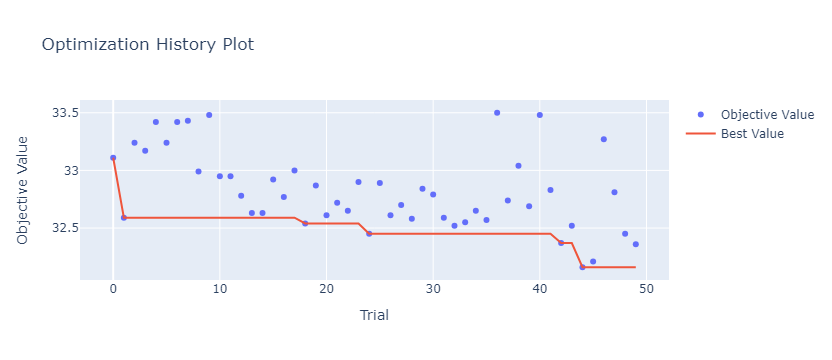

In [29]:
optuna.visualization.plot_optimization_history(study)

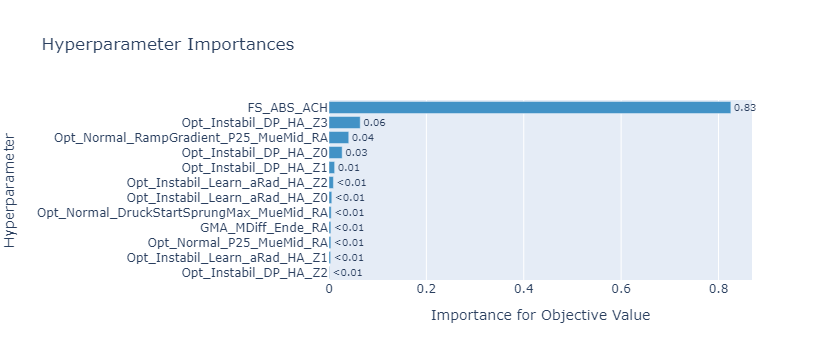

In [30]:
optuna.visualization.plot_param_importances(study)
# fig.write_image("inportance_values_plot.png")

In [31]:
# optuna.visualization.plot_contour(study, params=['P0', 'P1'])

In [3]:
# optuna.visualization.plot_slice(study, params=['P0', 'P1'])

In [4]:
# optuna.visualization.plot_intermediate_values(study)

## Read Result

In [9]:
with open('Sim_Result.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
    
print(loaded_data)

[(24.414798450958056, 'C:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CarSim_HGT_3A0A_BB85363_Var10_20230516\\2023-09-06_15-54-48-740252.csv', (461, 799, -17, 0.1680068178975952))]


# TEST

In [31]:
l_CSV = [f'{DIR}\\ABS\\simout_w_carsim_0.csv', f'{DIR}\\ABS\\simout_w_carsim_3.csv', f'{DIR}\\ABS\\simout_w_carsim_4.csv', f'{DIR}\\ABS\\simout_w_carsim_5.csv']
l_CSV_out = [f'{DIR}\\ABS\\simout_w_carsim_0_out.csv', f'{DIR}\\ABS\\simout_w_carsim_3_out.csv', f'{DIR}\\ABS\\simout_w_carsim_4_out.csv', f'{DIR}\\ABS\\simout_w_carsim_5_out.csv']

d_OUT = {}

for i, CSV in enumerate(l_CSV):
    e, CSV = ABS_Evaluation_w_CSV(CSV, l_CSV_out[i])
    # print(f'CSV:{CSV}, Evaluation:{e}')
    d_OUT[CSV] = e

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_25344\2027556691.py:31: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_25344\2027556691.py:32: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

In [32]:
d_OUT

{'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\ABS\\simout_w_carsim_0_out.csv': (2177.6321727377895,
  65.9400795,
  -0.2979187418937301),
 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\ABS\\simout_w_carsim_3_out.csv': (1999.3803504222146,
  65.9400795,
  -0.29538174452054794),
 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\ABS\\simout_w_carsim_4_out.csv': (2029.3577360418237,
  65.94022140000001,
  -0.29743960473807),
 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\ABS\\simout_w_carsim_5_out.csv': (2002.7398610448042,
  65.94022140000001,
  -0.29702797766101696)}

In [ ]:
  -0.2979187418937301
  -0.29538174452054794
  -0.29743960473807
  -0.29702797766101696

In [18]:
Command = 'c:\\TSDCT\\SharCC_PMSe\\spmse.exe importContainer -c=c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip'
subprocess.call(Command, shell=True)

0

In [19]:
Command = 'c:\\TSDCT\\SharCC_PMSe\\spmse.exe setActiveVariant -var=ESP10_BB87971'
subprocess.call(Command, shell=True)

0

In [20]:
Command = 'c:\\TSDCT\\SharCC_PMSe\\spmse.exe importDCM -d=c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\Complete_ESP10_BB87971_VarCode_1_org.dcm'
subprocess.call(Command, shell=True)

0

In [30]:
Command = 'c:\\TSDCT\\SharCC_PMSe\\spmse.exe importDCM -d=c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\20231222_223701511680.dcm'
subprocess.call(Command, shell=True)

0

In [31]:
# c:\TSDCT\SharCC_PMSe\spmse.exe saveSIM -s=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\DG8B_BB87971_Var01_Auto.sim
# subprocess.call(Command, shell=True)

In [32]:
Command = 'c:\\TSDCT\\SharCC_PMSe\\spmse.exe saveDCM -f=c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\DG8B_BB87971_Var01_Auto.dcm'
subprocess.call(Command, shell=True)

0

In [17]:
c:\TSDCT\SharCC_PMSe\spmse.exe exit
subprocess.call(Command, shell=True)

0

# RUN

In [24]:
DIR_DCM = 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\ABS\\Matsui_update'

l_DCM = utils.MakeTraceList([DIR_DCM], ['.dcm'], [])

['c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\ABS\\Matsui_update']


In [26]:
for DCM_ in l_DCM:
    l_DCM_ = [DCM_Org, DCM_]
    SIM, DCM_update = MakeSim(FILE_Appl, l_DCM_, FILE_Sim, PMSe_Variant)
    
    # result = eng.sim(FILE_Model)
    FILE_ZIP = Run_Matlab(MATLAB, DIR, FILE_Model, FILE_D97, FILE_CSV)
    
    # FILE_CSV_OUT, ZIP_OUT, D97_OUT = FileName(COUNT, DIR)
    # basename = os.path.basename(DCM_)
    root, ext = os.path.splitext(DCM_)
    FILE_CSV_OUT = f'{root}.csv'
    ZIP_OUT = f'{root}.zip'
    D97_OUT = f'{root}.d97'
    
    Eva, CSV = ABS_Evaluation_w_CSV(FILE_CSV, FILE_CSV_OUT, True)
    E_Slip, Distance, Deceleration = Eva
    print(f'{root}: {Eva}')
    
    PACK_D97(FILE_D97, ZIP_OUT, D97_OUT, [D97_OUT, DCM_update, CSV])
    # PACK_D97(FILE_D97, ZIP_OUT, D97_OUT, [DCM_update, CSV])
    # os.remove(DCM)
    os.remove(D97_OUT)

c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\Complete_ESP10_BB87971_VarCode_1_org.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ABS\Matsui_update/SIM_DG8B_Sedan_ABS_Snow_Spike_Rev0.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe saveSIM -s=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\DG8B_BB87971_Var01_Auto.sim

c:\TSDCT\SharCC_PMSe\spmse.exe saveDCM -f=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\DG8B_BB87971_Var01_Auto.dcm

c:\TSDCT\SharCC_PMSe

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev8.dcm: (1.2704891647808498, 33.31999999999999, -0.298605528115016)
c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\Complete_ESP10_BB87971_VarCode_1_org.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ABS\Matsui_update/SIM_DG8B_Sedan_ABS_Snow_Spike_Rev3.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe saveSIM -s=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\DG8B_BB87971_Var01_Auto.sim

c:\TSDCT\SharCC_PMSe\spmse.exe saveDCM -f=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_B

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev8.dcm: (1.2017484602531792, 33.03999999999999, -0.2991208143923241)
c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\Complete_ESP10_BB87971_VarCode_1_org.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ABS\Matsui_update/SIM_DG8B_Sedan_ABS_Snow_Spike_Rev4.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe saveSIM -s=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\DG8B_BB87971_Var01_Auto.sim

c:\TSDCT\SharCC_PMSe\spmse.exe saveDCM -f=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev8.dcm: (1.303928751269332, 33.41, -0.297571839596603)
c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\Complete_ESP10_BB87971_VarCode_1_org.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ABS\Matsui_update/SIM_DG8B_Sedan_ABS_Snow_Spike_Rev5.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe saveSIM -s=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\DG8B_BB87971_Var01_Auto.sim

c:\TSDCT\SharCC_PMSe\spmse.exe saveDCM -f=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev8.dcm: (1.2132850362959167, 32.81, -0.3045328891422367)
c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\Complete_ESP10_BB87971_VarCode_1_org.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ABS\Matsui_update/SIM_DG8B_Sedan_ABS_Snow_Spike_Rev6.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe saveSIM -s=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\DG8B_BB87971_Var01_Auto.sim

c:\TSDCT\SharCC_PMSe\spmse.exe saveDCM -f=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR0

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev8.dcm: (1.1420292523740412, 32.99000000000001, -0.29867895889243873)
c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\Complete_ESP10_BB87971_VarCode_1_org.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ABS\Matsui_update/SIM_DG8B_Sedan_ABS_Snow_Spike_Rev7.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe saveSIM -s=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\DG8B_BB87971_Var01_Auto.sim

c:\TSDCT\SharCC_PMSe\spmse.exe saveDCM -f=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev8.dcm: (1.2042061010812173, 32.59, -0.3071401116100767)
c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ApplContainer_BB87971_06000500_ESP10DG8B87971ASWSim.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87971

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\Complete_ESP10_BB87971_VarCode_1_org.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\ABS\Matsui_update/SIM_DG8B_Sedan_ABS_Snow_Spike_Rev8.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe saveSIM -s=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\DG8B_BB87971_Var01_Auto.sim

c:\TSDCT\SharCC_PMSe\spmse.exe saveDCM -f=c:\TSDE_Workarea\ktt2yk\CARSIM\CSSim_DG8B_BB87971_VAR0

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_12944\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatt

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev8.dcm: (1.2105512991124434, 32.76000000000002, -0.30422019511930587)


# Evaluation

In [15]:
DIR = 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\ABS\\'
l_DIR = [f'{DIR}Deceleration', f'{DIR}Distance', f'{DIR}E_Slip', f'{DIR}Matsui_update']
# l_DIR = [f'{DIR}Test']
l_EXT = ['.zip']

l_TRACE = utils.MakeTraceList(l_DIR, l_EXT, [])

['c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\ABS\\Deceleration', 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\ABS\\Distance', 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\ABS\\E_Slip', 'c:\\TSDE_Workarea\\ktt2yk\\CARSIM\\CSSim_DG8B_BB87971_VAR01_Matlab_2012b_64bits_20231218_CarSimNN\\ABS\\Matsui_update']


In [16]:
def UNPACK_FILE(Zip, Ext_tar):

    with zipfile.ZipFile(Zip, 'r') as zip_ref:
        # ZIPファイル内の全ファイル名のリストを取得
        file_list = zip_ref.namelist()
        # print(file_list)  # ファイルのリストを出力

    for F in file_list:
        root, ext = os.path.splitext(F)
        
        if ext == Ext_tar:
            F_tar = F
            break
        
    # ZIPファイルを開く
    with zipfile.ZipFile(Zip, 'r') as zip_ref:
        # 特定のファイルを抜き出す
        # zip_ref.extract('specific_file.txt', 'path/to/extract/directory')
        zip_ref.extract(F_tar)

    return F_tar

In [17]:
def PACK_INTO_ZIP(Zip, l_File):
    with zipfile.ZipFile(Zip, 'a') as zipf:
        for file_to_add in l_File:
            basename = os.path.basename(file_to_add)
            zipf.write(file_to_add, arcname=basename)

In [18]:
l_T = []
l_E_Slip = []
l_Distance = []
l_Deceleration = []

for T in l_TRACE:
    CSV = UNPACK_FILE(T, '.csv')
    CSV_out = CSV
    evaluation, CSV_out = ABS_Evaluation_w_CSV(CSV, CSV_out, False)
    basename = os.path.basename(CSV_out)
    print(f'{basename}: {evaluation}')
    # PACK_INTO_ZIP(T, [CSV])
    
    E_Slip, Distance, Deceleration = evaluation
    
    l_T.append(T)
    l_E_Slip.append(E_Slip)
    l_Distance.append(Distance)
    l_Deceleration.append(Deceleration)
    
d_Eva = {'Trace':l_T, 'E_Slip':l_E_Slip, 'Distance':l_Distance, 'Deceleration':l_Deceleration}

df_Eva = pd.DataFrame(d_Eva)

C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_0_20231226090955730337.csv: (1.2267715493863143, 33.110000000000014, -0.30096448594420605)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_10_20231226101722317863.csv: (1.1169705011504096, 32.95000000000002, -0.3020014272335845)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_11_20231226102412802211.csv: (1.137286881734056, 32.95000000000002, -0.3002422654175589)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_12_20231226103049111751.csv: (1.2115844144945433, 32.78, -0.30421103242950115)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_13_20231226103715785106.csv: (1.184887449259923, 32.629999999999995, -0.30775529187705813)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_14_20231226104415442010.csv: (1.1388336732315505, 32.629999999999995, -0.30836146182618257)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_15_20231226105104373646.csv: (1.1694676633544758, 32.920000000000016, -0.30591019945474374)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_16_20231226105748514888.csv: (1.2038089301921566, 32.77000000000001, -0.3054337275599128)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_17_20231226110440647698.csv: (1.1915289206933657, 33.0, -0.3030320755675676)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_18_20231226111129861581.csv: (1.1857494584930166, 32.53999999999999, -0.307565480372807)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_19_20231226111817515928.csv: (1.1120917959142713, 32.870000000000005, -0.29803208660998937)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_1_20231226091659945890.csv: (1.1978891460845973, 32.59, -0.30591475288985825)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_20_20231226112515420902.csv: (1.1882509012958267, 32.610000000000014, -0.3043243853420195)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_21_20231226113218365939.csv: (1.0897577815890613, 32.72, -0.30224253760775854)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_22_20231226113932308317.csv: (1.086226907028279, 32.650000000000006, -0.30289352365010797)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_23_20231226114628164972.csv: (1.1175443963030245, 32.900000000000006, -0.30054470085744905)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_24_20231226115323691044.csv: (1.2309446321403674, 32.45000000000002, -0.30605572041484713)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_25_20231226120014210918.csv: (1.2759374247050181, 32.890000000000015, -0.30542571993464057)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_26_20231226120706752220.csv: (1.1723852007514928, 32.610000000000014, -0.3055826785403051)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_27_20231226121316168614.csv: (1.1086942918321987, 32.70000000000002, -0.30505407606093576)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_28_20231226121919439392.csv: (1.1658266464979432, 32.58000000000001, -0.3058021076335877)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_29_20231226122523423778.csv: (1.1854863311422839, 32.84, -0.3026086719525351)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_2_20231226092337853637.csv: (1.0611710498532059, 33.24000000000001, -0.300793994527897)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_30_20231226123131677353.csv: (1.1344936692812435, 32.78999999999999, -0.3050717340587595)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_31_20231226123732015825.csv: (1.1711493967301858, 32.59, -0.30736945043859654)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_32_20231226124334523783.csv: (1.1841534055002074, 32.52000000000001, -0.3078731854006586)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_33_20231226125009520088.csv: (1.1912174753450184, 32.55000000000001, -0.30646739879781415)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_34_20231226125644189981.csv: (1.1108828835171094, 32.650000000000006, -0.30530579140369973)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_35_20231226130341834092.csv: (1.2232339793721296, 32.56999999999999, -0.30729701478641835)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_36_20231226131031768235.csv: (1.0847055347897727, 33.5, -0.2976761495753716)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_37_20231226131716324547.csv: (1.1378337994551504, 32.74000000000001, -0.30391022881906826)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_38_20231226132409813643.csv: (1.1333356466045772, 33.03999999999999, -0.3043876394136808)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_39_20231226133053171668.csv: (1.2032726478348825, 32.69, -0.30746153388157893)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_3_20231226093001203154.csv: (1.1437328327236176, 33.170000000000016, -0.30194015274488695)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_40_20231226133702586454.csv: (1.087553453032217, 33.48000000000002, -0.2979577926673751)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_41_20231226134319684401.csv: (1.1454264538522367, 32.83000000000001, -0.3027122083153348)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_42_20231226134940164690.csv: (1.0910837237728872, 32.370000000000005, -0.30628131517467244)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_43_20231226135553482159.csv: (1.2051395237842335, 32.52000000000001, -0.3078179131723381)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_44_20231226140213567826.csv: (1.2599956743441685, 32.16, -0.30628153045851525)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_45_20231226140828578678.csv: (1.2303886147705352, 32.21000000000001, -0.30861107029702967)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_46_20231226141451097648.csv: (1.0257475182855242, 33.27000000000001, -0.2982834020212766)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_47_20231226142109661537.csv: (1.084929596420091, 32.81, -0.29957136955128205)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_48_20231226142730540293.csv: (1.0992133091298466, 32.45000000000002, -0.30584751679389316)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_49_20231226143348573780.csv: (1.1653578802823967, 32.360000000000014, -0.30601908067685585)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_4_20231226093717674793.csv: (0.9991676562703223, 33.420000000000016, -0.29544663951527916)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_5_20231226094338035371.csv: (1.1098084168709135, 33.24000000000001, -0.3003164206638115)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_6_20231226095016541346.csv: (1.0331545329378122, 33.420000000000016, -0.29721649565677966)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_7_20231226095659088379.csv: (1.1630055538004584, 33.43000000000001, -0.29827679882978725)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_8_20231226100347923873.csv: (1.0325197564227093, 32.99000000000001, -0.29855898072417464)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_9_20231226101027402865.csv: (1.054318490274134, 33.48000000000002, -0.2964270442917548)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_0_20231223000211115520.csv: (1.1217196900227075, 33.5, -0.2965892128964059)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_10_20231223005418230032.csv: (1.1906090935192981, 33.349999999999994, -0.2983135084042553)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_11_20231223005929221735.csv: (1.1803470610947493, 33.349999999999994, -0.29743040180275715)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_12_20231223010446886091.csv: (1.1750011227185577, 33.370000000000005, -0.2979076736450585)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_13_20231223011001583058.csv: (1.214603959815018, 33.31, -0.29964365160256407)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_14_20231223011516723121.csv: (1.0484191805560847, 33.420000000000016, -0.29862109574014917)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_15_20231223012028800146.csv: (1.1657541781874625, 33.33000000000001, -0.2972425046659597)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_16_20231223012539562534.csv: (1.1014247052008022, 33.34, -0.3011257238453276)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_17_20231223013049203788.csv: (0.9774607107224785, 33.47, -0.296051710031679)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_18_20231223013603231298.csv: (1.2329490253471325, 33.25, -0.2998838298395722)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_19_20231223014118795866.csv: (1.0844240120213346, 33.390000000000015, -0.29808530276301803)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_1_20231223000724547839.csv: (1.0190512530897844, 33.620000000000005, -0.2972079554025424)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_20_20231223014640891560.csv: (1.0503804400550731, 33.53, -0.2977197406581741)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_21_20231223015152694916.csv: (-10000, 10000, 10000)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_22_20231223015703665266.csv: (1.1842610518071226, 33.51000000000002, -0.2967270316402116)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_23_20231223020215120137.csv: (1.1433814777458702, 33.24000000000001, -0.30126483501611173)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_24_20231223020729095109.csv: (1.0866214663806675, 33.390000000000015, -0.2974727581124072)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_25_20231223021241302448.csv: (1.1591252674700436, 33.30000000000001, -0.299859169946524)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_26_20231223021750796420.csv: (-10000, 10000, 10000)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_27_20231223022310993180.csv: (-10000, 10000, 10000)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_28_20231223022823587489.csv: (1.1286676288043607, 33.150000000000006, -0.3022109880387931)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_29_20231223023336190174.csv: (1.1345788070899407, 33.370000000000005, -0.2992714630736393)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_2_20231223001236892238.csv: (1.1224478253975596, 33.78999999999999, -0.29581274767932486)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_30_20231223023849158701.csv: (1.1380704796635956, 33.27000000000001, -0.3003280299785867)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_31_20231223024403814405.csv: (1.1822401205270048, 33.33000000000001, -0.298892984424307)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_32_20231223024926301321.csv: (1.2518264479306593, 33.53999999999999, -0.2995168001068376)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_33_20231223025438065384.csv: (-10000, 10000, 10000)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_34_20231223025949989638.csv: (1.2697597960838507, 33.47, -0.30110364436090226)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_35_20231223030504378352.csv: (1.1620492790780117, 33.390000000000015, -0.2972007827330509)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_36_20231223031038265882.csv: (1.1565599772610906, 33.81, -0.2963655371035941)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_37_20231223031557197609.csv: (1.2056065443070836, 33.26000000000002, -0.29878406698615545)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_38_20231223032115048019.csv: (-10000, 10000, 10000)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_39_20231223032632939122.csv: (1.1568928693333833, 33.34, -0.2982872540425532)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_3_20231223001749761624.csv: (0.9610259307802069, 33.629999999999995, -0.29572484694092827)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_40_20231223033208707037.csv: (1.218127813329973, 33.360000000000014, -0.29836427755319145)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_41_20231223033726815863.csv: (-10000, 10000, 10000)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_42_20231223034251918420.csv: (1.0813246124531977, 33.629999999999995, -0.2948852449001051)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_43_20231223034814104040.csv: (1.217055020427063, 33.21000000000001, -0.299700384508547)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_44_20231223035331710119.csv: (1.2609826035902687, 33.53999999999999, -0.2996408919871794)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_45_20231223035850302499.csv: (1.114807898844627, 33.150000000000006, -0.30059249292604495)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_46_20231223040411987414.csv: (1.2312623604105903, 33.640000000000015, -0.2970247075211864)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_47_20231223040933876029.csv: (1.1387652173164868, 33.420000000000016, -0.29570489324894517)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_48_20231223041456618931.csv: (-10000, 10000, 10000)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_49_20231223042018514180.csv: (1.2297584371046046, 33.21000000000001, -0.30066257331189705)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_4_20231223002304118519.csv: (1.0575163804020768, 33.56999999999999, -0.29665701365079367)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_50_20231223042536266275.csv: (1.0988322260193657, 33.23000000000002, -0.29888567579957354)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_51_20231223043053761452.csv: (1.23987881704453, 33.02000000000001, -0.3047118444565217)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_52_20231223043612808211.csv: (1.2068669060027901, 33.66, -0.29568248723628693)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_53_20231223044134192781.csv: (1.1816757480509685, 33.33000000000001, -0.2993700340448239)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_54_20231223044653975439.csv: (1.2080093005045731, 33.78, -0.2933985365062762)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_55_20231223045214561454.csv: (1.0164072468549048, 33.56, -0.29707972341101696)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_56_20231223045734646229.csv: (1.1682223552729818, 33.25, -0.3009109215665236)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_57_20231223050254438055.csv: (1.1913582023934226, 33.25, -0.29982647155080205)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_58_20231223050818088027.csv: (1.240230696282051, 33.21000000000001, -0.3003487375802998)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_59_20231223051340343073.csv: (-10000, 10000, 10000)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_5_20231223002817732802.csv: (1.0852668194177904, 33.670000000000016, -0.2943545046169989)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_60_20231223051900722888.csv: (1.126327343821635, 33.26000000000002, -0.2994542894230769)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_61_20231223052431791337.csv: (1.2584706911121053, 33.51000000000002, -0.3008586672746781)
Traial_62_20231223052950295903.csv: (-10000, 10000, 10000)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_63_20231223053507408017.csv: (1.259948989355974, 33.52000000000001, -0.2993321215581644)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_64_20231223054028623150.csv: (1.036683303204183, 33.56999999999999, -0.29708777637711864)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_65_20231223054550701289.csv: (1.1760177057519583, 33.400000000000006, -0.2982297541489362)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_66_20231223055110972991.csv: (1.1382144072087719, 33.28, -0.2990361398720683)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_67_20231223055636650049.csv: (1.0986242961887578, 33.379999999999995, -0.2978734207226355)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_68_20231223060155295095.csv: (1.1166405207982173, 33.33000000000001, -0.30112703641245975)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_69_20231223060718637619.csv: (1.2226321907183129, 33.41, -0.2986728912673057)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_6_20231223003328652610.csv: (1.0172830925982257, 33.150000000000006, -0.29696206027542377)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_70_20231223061241260141.csv: (1.1786599587741433, 33.22, -0.29934905218783353)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_71_20231223061812188271.csv: (1.2271862883652582, 33.30000000000001, -0.29977830042780745)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_72_20231223062332161726.csv: (1.2444341414575366, 33.599999999999994, -0.2990520777185501)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_73_20231223062854643152.csv: (1.2254362835665116, 33.56999999999999, -0.2990888751599148)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_74_20231223063415864735.csv: (1.2493076152742726, 33.56999999999999, -0.29952165053418806)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_75_20231223063940858982.csv: (1.210719374687419, 33.26000000000002, -0.3016603160215054)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_76_20231223064505811190.csv: (1.1572959145858388, 33.26000000000002, -0.30178258439181915)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_77_20231223065051217647.csv: (1.1643973572565445, 33.25, -0.30007356245989303)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_78_20231223065625378961.csv: (1.181646385186278, 33.06999999999999, -0.30166311279569896)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_79_20231223070152573596.csv: (1.252025581939112, 33.06999999999999, -0.30190729590958015)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_7_20231223003839940674.csv: (0.960323379427283, 33.77000000000001, -0.2914995352390853)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_80_20231223070726810539.csv: (1.1934051247875705, 33.22, -0.30153508053763434)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_81_20231223071255689624.csv: (1.1646790915228025, 33.75, -0.29375641036649214)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_82_20231223071818485771.csv: (1.15390202702015, 33.68000000000001, -0.2973582872746554)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_83_20231223072339706110.csv: (1.1423171512258936, 33.28999999999999, -0.29949178301282053)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_84_20231223072902936575.csv: (1.235956098958657, 33.47, -0.3004048166130761)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_85_20231223073423684303.csv: (1.1912687689578174, 33.099999999999994, -0.3022661410560345)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_86_20231223073943398801.csv: (1.1659346208208161, 33.21000000000001, -0.3006366440514469)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_87_20231223074505043778.csv: (-10000, 10000, 10000)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_88_20231223075023800457.csv: (1.1665748480230558, 33.53999999999999, -0.299391389434365)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_89_20231223075546706921.csv: (1.116710489053979, 33.390000000000015, -0.29870852215122473)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_8_20231223004351021845.csv: (1.0267404417190915, 33.420000000000016, -0.2957386243670886)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_90_20231223080110540703.csv: (1.214001999918065, 33.110000000000014, -0.3040170009761388)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_91_20231223080637202172.csv: (1.2515559383158446, 33.599999999999994, -0.2998362940106953)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_92_20231223081201562040.csv: (1.1801605488103821, 33.34, -0.2976366209129512)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_93_20231223081723518263.csv: (1.2262192881861356, 33.27000000000001, -0.29956542831196586)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_94_20231223082244832208.csv: (1.2723297694120446, 33.53, -0.30083333036480686)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_95_20231223082804518106.csv: (-10000, 10000, 10000)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_96_20231223083336855282.csv: (-10000, 10000, 10000)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_97_20231223083905591425.csv: (1.1827143493427392, 33.22, -0.3000279453475936)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_98_20231223084432760442.csv: (1.0753224711514335, 33.400000000000006, -0.2965521342857143)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_99_20231223084953533692.csv: (1.1775942501353809, 33.28999999999999, -0.30028389389721627)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

Traial_9_20231223004906836769.csv: (-10000, 10000, 10000)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev0.csv: (1.170135183262369, 33.31999999999999, -0.298605528115016)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev3.csv: (1.0917523551530142, 33.03999999999999, -0.2991208143923241)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev4.csv: (1.182596185490926, 33.41, -0.297571839596603)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev5.csv: (1.101405472007396, 32.81, -0.3045328891422367)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev6.csv: (1.0613845052251618, 32.99000000000001, -0.29867895889243873)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev7.csv: (1.185455266412876, 32.59, -0.3071401116100767)


C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:34: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(X, Y, Z)
C:\Users\ktt2yk\AppData\Local\Temp\ipykernel_2512\1873694180.py:35: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scatter

SIM_DG8B_Sedan_ABS_Snow_Spike_Rev8.csv: (1.1341664844379367, 32.76000000000002, -0.30422019511930587)


In [19]:
df_Eva.to_csv('ABS_Eva.csv')

# Make HEX

In [65]:
DIR = 'c:\\mt\\mt\\DG8B\\Winter_2024'
FILE_Appl = f'{DIR}\\ApplContainer_BB87973_09000800_ESP10DG8B87973XCP.appl.zip'
PMSe_Variant = 'ESP10_BB87973'
VarCode = '21'
File_Add = f'DG8B_BB87973_Var{VarCode}_'

In [66]:
DIR_DCM = 'c:\\mt\\mt\\DG8B\\Winter_2024\\DCM_Changed'

l_DCM = [f'{DIR_DCM}\\ABS_App_Tuning.dcm',
         f'{DIR_DCM}\\ABS_Distance.dcm',
         f'{DIR_DCM}\\PreWinter_fix.dcm',
         f'{DIR_DCM}\\VDC_ActiveUScontrol.dcm',
         f'{DIR_DCM}\\VDC_ActiveUScontrol_forSimEffect.dcm',
         f'{DIR_DCM}\\VDC_QuickOScontrol.dcm',
         f'{DIR_DCM}\\VDC_QuickOScontrol_forSimEffect.dcm']

# l_DCM = [f'{DIR_DCM}\\ABS_App_Tuning.dcm']

In [67]:
l_OUT = []

for DCM in l_DCM:
    base_name = os.path.basename(DCM)
    file_name, file_extension = os.path.splitext(base_name)
    directory_name = os.path.dirname(DCM)
    
    HEX = f'{directory_name}\\{File_Add}{file_name}.hex' 
    
    HEX, DCM = MakeHex(FILE_Appl, [DCM], HEX, PMSe_Variant, VarCode)
    l_OUT = (HEX, DCM)

c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\mt\mt\DG8B\Winter_2024\ApplContainer_BB87973_09000800_ESP10DG8B87973XCP.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87973

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\mt\mt\DG8B\Winter_2024\DCM_Changed\ABS_App_Tuning.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe saveHEX -hex=c:\mt\mt\DG8B\Winter_2024\DCM_Changed\DG8B_BB87973_Var21_ABS_App_Tuning.hex

c:\TSDCT\SharCC_PMSe\spmse.exe saveDCM -f=c:\mt\mt\DG8B\Winter_2024\DCM_Changed\DG8B_BB87973_Var21_ABS_App_Tuning.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe exit
c:\TSDCT\SharCC_PMSe\spmse.exe importContainer -c=c:\mt\mt\DG8B\Winter_2024\ApplContainer_BB87973_09000800_ESP10DG8B87973XCP.appl.zip

c:\TSDCT\SharCC_PMSe\spmse.exe setActiveVariant -var=ESP10_BB87973

c:\TSDCT\SharCC_PMSe\spmse.exe importDCM -d=c:\mt\mt\DG8B\Winter_2024\DCM_Changed\ABS_Distance.dcm

c:\TSDCT\SharCC_PMSe\spmse.exe saveHEX -hex=c:\mt\mt\DG8B\Winter_2024\DCM_Changed\DG8B_BB87973_Var21_ABS_Distance.he

In [47]:
l_OUT

('c:\\mt\\mt\\DG8B\\Winter_2024\\DCM_Changed\\DG8B_BB87973_Var22_ABS_App_Tuning.hex',
 'c:\\mt\\mt\\DG8B\\Winter_2024\\DCM_Changed\\DG8B_BB87973_Var22_ABS_App_Tuning.dcm')